# Import packages


In [1]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings

# Load data


In [2]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


In [3]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [4]:
train_data, test_data, all_data, test_data_start_list = load_data(stock_name, date_predict_start, data_range, slide_range, n_slide)

In [5]:
all_data.iloc[23449]

Open            4.228290e+03
High            4.236390e+03
Low             4.188130e+03
Close           4.188430e+03
Volume          4.560700e+09
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Name: 2021-05-10, dtype: float64

In [6]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0
...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0


# Data preprocessing


In [7]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [8]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [9]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [10]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [11]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [12]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [13]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [14]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [15]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [16]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [17]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [18]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [19]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [20]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [21]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [22]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [23]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [24]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [25]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [26]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [27]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [28]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

In [29]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)


In [30]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,2953.909912,NaN,peak
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [31]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.random import shuffle

In [32]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [33]:
base_day = 50
prediction_day = base_day
slide = base_day

In [34]:
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)

In [35]:
x_train['data_0'].shape

(150, 50, 1)

In [36]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units=prediction_day))
    return model

In [37]:
input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)

In [38]:
def build_Lstm_model(prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [39]:
model = build_Lstm_model(prediction_day, input_shape)

In [40]:
from tqdm import tqdm

In [41]:
def train_Lstm_model():
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [42]:
history = train_Lstm_model()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
4/4 [==============================] - 22s 2s/step - loss: 0.0458 - val_loss: 0.1942
Epoch 2/25
4/4 [==============================] - 1s 330ms/step - loss: 0.0359 - val_loss: 0.1491
Epoch 3/25
4/4 [==============================] - 1s 346ms/step - loss: 0.0323 - val_loss: 0.1235
Epoch 4/25
4/4 [==============================] - 2s 413ms/step - loss: 0.0290 - val_loss: 0.1141
Epoch 5/25
4/4 [==============================] - 1s 316ms/step - loss: 0.0268 - val_loss: 0.1029
Epoch 6/25
4/4 [==============================] - 1s 339ms/step - loss: 0.0252 - val_loss: 0.1036
Epoch 7/25
4/4 [==============================] - 1s 341ms/step - loss: 0.0240 - val_loss: 0.1061
Epoch 8/25
4/4 [==============================] - 1s 318ms/step - loss: 0.0226 - val_loss: 0.1139
Epoch 9/25
4/4 [==============================] - 2s 406ms/step - loss: 0.0214 - val_loss: 0.0851
Epoch 10/25
4/4 [==============================] - 2s 411ms/step - loss: 0.0194 - val_loss: 0.0891
Epoch 11/25
4/4 [====

 10%|█         | 1/10 [00:41<06:17, 41.93s/it]

Epoch 1/25
4/4 [==============================] - 28s 1s/step - loss: 0.0470 - val_loss: 0.2314
Epoch 2/25
4/4 [==============================] - 1s 311ms/step - loss: 0.0432 - val_loss: 0.2153
Epoch 3/25
4/4 [==============================] - 1s 306ms/step - loss: 0.0402 - val_loss: 0.1903
Epoch 4/25
4/4 [==============================] - 1s 305ms/step - loss: 0.0357 - val_loss: 0.1517
Epoch 5/25
4/4 [==============================] - 1s 393ms/step - loss: 0.0324 - val_loss: 0.1819
Epoch 6/25
4/4 [==============================] - 1s 308ms/step - loss: 0.0312 - val_loss: 0.1896
Epoch 7/25
4/4 [==============================] - 2s 384ms/step - loss: 0.0284 - val_loss: 0.1641
Epoch 8/25
4/4 [==============================] - 1s 380ms/step - loss: 0.0280 - val_loss: 0.1720
Epoch 9/25
4/4 [==============================] - 1s 296ms/step - loss: 0.0261 - val_loss: 0.1563
Epoch 9: early stopping


 20%|██        | 2/10 [01:20<05:21, 40.21s/it]

Epoch 1/25
4/4 [==============================] - 33s 2s/step - loss: 0.0923 - val_loss: 0.2675
Epoch 2/25
4/4 [==============================] - 1s 303ms/step - loss: 0.0712 - val_loss: 0.3175
Epoch 3/25
4/4 [==============================] - 1s 305ms/step - loss: 0.0612 - val_loss: 0.2709
Epoch 4/25
4/4 [==============================] - 1s 356ms/step - loss: 0.0564 - val_loss: 0.2896
Epoch 5/25
4/4 [==============================] - 1s 305ms/step - loss: 0.0499 - val_loss: 0.2759
Epoch 6/25
4/4 [==============================] - 2s 429ms/step - loss: 0.0453 - val_loss: 0.2091
Epoch 7/25
4/4 [==============================] - 2s 421ms/step - loss: 0.0447 - val_loss: 0.2222
Epoch 8/25
4/4 [==============================] - 2s 409ms/step - loss: 0.0443 - val_loss: 0.2678
Epoch 9/25
4/4 [==============================] - 2s 422ms/step - loss: 0.0418 - val_loss: 0.2806
Epoch 10/25
4/4 [==============================] - 2s 429ms/step - loss: 0.0403 - val_loss: 0.2310
Epoch 11/25
4/4 [====

 30%|███       | 3/10 [02:09<05:06, 43.82s/it]

Epoch 1/25
4/4 [==============================] - 32s 2s/step - loss: 0.1252 - val_loss: 0.3213
Epoch 2/25
4/4 [==============================] - 1s 319ms/step - loss: 0.0921 - val_loss: 0.2834
Epoch 3/25
4/4 [==============================] - 1s 358ms/step - loss: 0.0768 - val_loss: 0.3071
Epoch 4/25
4/4 [==============================] - 1s 341ms/step - loss: 0.0690 - val_loss: 0.3033
Epoch 5/25
4/4 [==============================] - 1s 369ms/step - loss: 0.0655 - val_loss: 0.2741
Epoch 6/25
4/4 [==============================] - 2s 397ms/step - loss: 0.0652 - val_loss: 0.3159
Epoch 7/25
4/4 [==============================] - 2s 423ms/step - loss: 0.0611 - val_loss: 0.2899
Epoch 8/25
4/4 [==============================] - 2s 422ms/step - loss: 0.0598 - val_loss: 0.2850
Epoch 9/25
4/4 [==============================] - 2s 420ms/step - loss: 0.0574 - val_loss: 0.2732
Epoch 10/25
4/4 [==============================] - 2s 418ms/step - loss: 0.0583 - val_loss: 0.2846
Epoch 11/25
4/4 [====

 40%|████      | 4/10 [03:12<05:10, 51.76s/it]

Epoch 1/25
4/4 [==============================] - 31s 4s/step - loss: 0.1180 - val_loss: 0.3610
Epoch 2/25
4/4 [==============================] - 2s 423ms/step - loss: 0.0907 - val_loss: 0.3540
Epoch 3/25
4/4 [==============================] - 2s 394ms/step - loss: 0.0821 - val_loss: 0.3323
Epoch 4/25
4/4 [==============================] - 2s 390ms/step - loss: 0.0787 - val_loss: 0.3454
Epoch 5/25
4/4 [==============================] - 2s 399ms/step - loss: 0.0721 - val_loss: 0.3263
Epoch 6/25
4/4 [==============================] - 2s 405ms/step - loss: 0.0695 - val_loss: 0.3195
Epoch 7/25
4/4 [==============================] - 2s 407ms/step - loss: 0.0646 - val_loss: 0.2866
Epoch 8/25
4/4 [==============================] - 2s 390ms/step - loss: 0.0619 - val_loss: 0.2524
Epoch 9/25
4/4 [==============================] - 1s 376ms/step - loss: 0.0654 - val_loss: 0.2713
Epoch 10/25
4/4 [==============================] - 1s 332ms/step - loss: 0.0585 - val_loss: 0.2916
Epoch 11/25
4/4 [====

 50%|█████     | 5/10 [04:16<04:40, 56.07s/it]

Epoch 1/25
4/4 [==============================] - 33s 2s/step - loss: 0.0770 - val_loss: 0.3440
Epoch 2/25
4/4 [==============================] - 1s 367ms/step - loss: 0.0553 - val_loss: 0.2344
Epoch 3/25
4/4 [==============================] - 1s 322ms/step - loss: 0.0422 - val_loss: 0.1823
Epoch 4/25
4/4 [==============================] - 1s 330ms/step - loss: 0.0373 - val_loss: 0.1748
Epoch 5/25
4/4 [==============================] - 1s 334ms/step - loss: 0.0345 - val_loss: 0.1459
Epoch 6/25
4/4 [==============================] - 1s 320ms/step - loss: 0.0330 - val_loss: 0.1415
Epoch 7/25
4/4 [==============================] - 2s 407ms/step - loss: 0.0306 - val_loss: 0.1195
Epoch 8/25
4/4 [==============================] - 2s 408ms/step - loss: 0.0306 - val_loss: 0.1178
Epoch 9/25
4/4 [==============================] - 1s 375ms/step - loss: 0.0297 - val_loss: 0.0941
Epoch 10/25
4/4 [==============================] - 1s 355ms/step - loss: 0.0289 - val_loss: 0.0898
Epoch 11/25
4/4 [====

 60%|██████    | 6/10 [05:10<03:40, 55.16s/it]

Epoch 1/25
4/4 [==============================] - 24s 1s/step - loss: 0.1763 - val_loss: 0.4023
Epoch 2/25
4/4 [==============================] - 1s 317ms/step - loss: 0.1004 - val_loss: 0.2701
Epoch 3/25
4/4 [==============================] - 1s 324ms/step - loss: 0.0664 - val_loss: 0.2263
Epoch 4/25
4/4 [==============================] - 1s 381ms/step - loss: 0.0531 - val_loss: 0.2140
Epoch 5/25
4/4 [==============================] - 1s 371ms/step - loss: 0.0457 - val_loss: 0.1814
Epoch 6/25
4/4 [==============================] - 2s 369ms/step - loss: 0.0392 - val_loss: 0.1802
Epoch 7/25
4/4 [==============================] - 2s 376ms/step - loss: 0.0383 - val_loss: 0.1889
Epoch 8/25
4/4 [==============================] - 1s 319ms/step - loss: 0.0380 - val_loss: 0.1811
Epoch 9/25
4/4 [==============================] - 1s 311ms/step - loss: 0.0355 - val_loss: 0.1940
Epoch 10/25
4/4 [==============================] - 1s 383ms/step - loss: 0.0338 - val_loss: 0.1859
Epoch 11/25
4/4 [====

 70%|███████   | 7/10 [05:58<02:38, 52.89s/it]

Epoch 1/25
4/4 [==============================] - 25s 1s/step - loss: 0.2168 - val_loss: 0.4788
Epoch 2/25
4/4 [==============================] - 1s 301ms/step - loss: 0.1271 - val_loss: 0.4223
Epoch 3/25
4/4 [==============================] - 1s 341ms/step - loss: 0.0816 - val_loss: 0.3951
Epoch 4/25
4/4 [==============================] - 1s 342ms/step - loss: 0.0634 - val_loss: 0.3884
Epoch 5/25
4/4 [==============================] - 1s 312ms/step - loss: 0.0515 - val_loss: 0.4057
Epoch 6/25
4/4 [==============================] - 2s 401ms/step - loss: 0.0439 - val_loss: 0.4327
Epoch 7/25
4/4 [==============================] - 2s 402ms/step - loss: 0.0384 - val_loss: 0.4796
Epoch 8/25
4/4 [==============================] - 1s 390ms/step - loss: 0.0328 - val_loss: 0.5798
Epoch 9/25
4/4 [==============================] - 2s 394ms/step - loss: 0.0396 - val_loss: 0.5210
Epoch 9: early stopping


 80%|████████  | 8/10 [06:34<01:35, 47.61s/it]

Epoch 1/25
4/4 [==============================] - 16s 2s/step - loss: 0.2647 - val_loss: 0.4313
Epoch 2/25
4/4 [==============================] - 1s 319ms/step - loss: 0.1562 - val_loss: 0.4696
Epoch 3/25
4/4 [==============================] - 1s 363ms/step - loss: 0.0992 - val_loss: 0.4989
Epoch 4/25
4/4 [==============================] - 1s 382ms/step - loss: 0.0852 - val_loss: 0.5386
Epoch 5/25
4/4 [==============================] - 2s 451ms/step - loss: 0.0725 - val_loss: 0.5444
Epoch 6/25
4/4 [==============================] - 1s 374ms/step - loss: 0.0586 - val_loss: 0.6306
Epoch 6: early stopping


 90%|█████████ | 9/10 [06:58<00:40, 40.11s/it]

Epoch 1/25
4/4 [==============================] - 15s 1s/step - loss: 0.2958 - val_loss: 0.4537
Epoch 2/25
4/4 [==============================] - 1s 383ms/step - loss: 0.1900 - val_loss: 0.4754
Epoch 3/25
4/4 [==============================] - 1s 351ms/step - loss: 0.1332 - val_loss: 0.5377
Epoch 4/25
4/4 [==============================] - 1s 292ms/step - loss: 0.1101 - val_loss: 0.5702
Epoch 5/25
4/4 [==============================] - 1s 327ms/step - loss: 0.0993 - val_loss: 0.6608
Epoch 6/25
4/4 [==============================] - 1s 294ms/step - loss: 0.0886 - val_loss: 0.6718
Epoch 6: early stopping


100%|██████████| 10/10 [07:20<00:00, 44.00s/it]


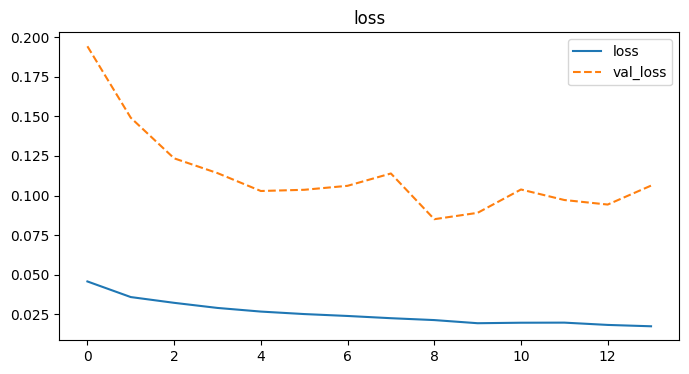

In [43]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()


In [44]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [45]:
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

In [46]:
test_data['data_2']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-01-31,3282.330078,3282.330078,3214.679932,3225.520020,4529700000,0.0,0.0,NaN,3225.520020,valley
1,2020-02-03,3235.659912,3268.439941,3235.659912,3248.919922,3760460000,0.0,0.0,NaN,NaN,NaN
2,2020-02-04,3280.610107,3306.919922,3280.610107,3297.590088,3996900000,0.0,0.0,NaN,NaN,NaN
3,2020-02-05,3324.909912,3337.580078,3313.750000,3334.689941,4121480000,0.0,0.0,NaN,NaN,NaN
4,2020-02-06,3344.919922,3347.959961,3334.389893,3345.780029,3887250000,0.0,0.0,3345.780029,NaN,peak
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-01-21,3857.459961,3861.449951,3845.050049,3853.070068,4501760000,0.0,0.0,3853.070068,NaN,peak
246,2021-01-22,3844.239990,3852.310059,3830.409912,3841.469971,5110890000,0.0,0.0,NaN,3841.469971,valley
247,2021-01-25,3851.679932,3859.229980,3797.159912,3855.360107,7000840000,0.0,0.0,3855.360107,NaN,peak
248,2021-01-26,3862.959961,3870.899902,3847.780029,3849.620117,6137500000,0.0,0.0,NaN,NaN,NaN


In [47]:
def predicting_creat_processed_signal_Lstm(x_test, test_data):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [48]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data)

1/1 [==============================] - 2s 2s/step


In [49]:
processed_signal['data_0'][0]

,Close
0,0.178605
1,0.186453
2,0.131108
3,0.147386
4,0.234239
...,...
195,0.389809
196,0.514151
197,0.460205
198,0.446774


In [50]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)


In [51]:
# processed_signal = processed_signal_FFT

In [52]:
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

In [53]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [54]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,2953.909912,NaN,peak
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [55]:
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)

In [56]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,2953.909912,NaN,peak
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [57]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [58]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date t_date lead ans_date      pv error best_fit
data_0  2020-01-02    NaN -1.0      NaN  valley  2.01        0
data_1  2020-01-16    NaN -1.0      NaN  valley   2.0        0
data_2  2020-01-31    NaN  3.0      NaN    peak  2.32        0
data_3  2020-02-14    NaN  6.0      NaN  valley  2.28        0
data_4  2020-03-02    NaN  3.0      NaN  valley  2.44        0
data_5  2020-03-16    NaN  4.0      NaN  valley  2.35        0
data_6  2020-03-30    NaN  2.0      NaN    peak  2.28        0
data_7  2020-04-14    NaN  0.0      NaN  valley  2.72        0
data_8  2020-04-28    NaN -1.0      NaN    peak   2.4        0
data_9  2020-05-12    NaN  3.0      NaN    peak  2.91        0


In [59]:
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date      t_date lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-06 -1.0  2020-01-03  valley  2.01        0
data_1  2020-01-16  2020-01-17 -1.0  2020-01-16  valley   2.0        0
data_2  2020-01-31  2020-02-03  3.0  2020-02-06    peak  2.32        0
data_3  2020-02-14  2020-02-20  6.0  2020-02-28  valley  2.28        0
data_4  2020-03-02  2020-03-04  3.0  2020-03-09  valley  2.44        0
data_5  2020-03-16  2020-03-17  4.0  2020-03-23  valley  2.35        0
data_6  2020-03-30  2020-04-02  2.0  2020-04-06    peak  2.28        0
data_7  2020-04-14  2020-04-15  0.0  2020-04-15  valley  2.72        0
data_8  2020-04-28  2020-04-30 -1.0  2020-04-29    peak   2.4        0
data_9  2020-05-12  2020-05-13  3.0  2020-05-18    peak  2.91        0


In [60]:
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  2.4
            s_date      t_date lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-06 -1.0  2020-01-03  valley  2.01        0
data_1  2020-01-16  2020-01-17 -1.0  2020-01-16  valley   2.0        0
data_2  2020-01-31  2020-02-03  3.0  2020-02-06    peak  2.32        0
data_3  2020-02-14  2020-02-20  6.0  2020-02-28  valley  2.28        0
data_4  2020-03-02  2020-03-04  3.0  2020-03-09  valley  2.44        0
data_5  2020-03-16  2020-03-17  4.0  2020-03-23  valley  2.35        0
data_6  2020-03-30  2020-04-02  2.0  2020-04-06    peak  2.28        0
data_7  2020-04-14  2020-04-15  0.0  2020-04-15  valley  2.72        0
data_8  2020-04-28  2020-04-30 -1.0  2020-04-29    peak   2.4        0
data_9  2020-05-12  2020-05-13  3.0  2020-05-18    peak  2.91        0


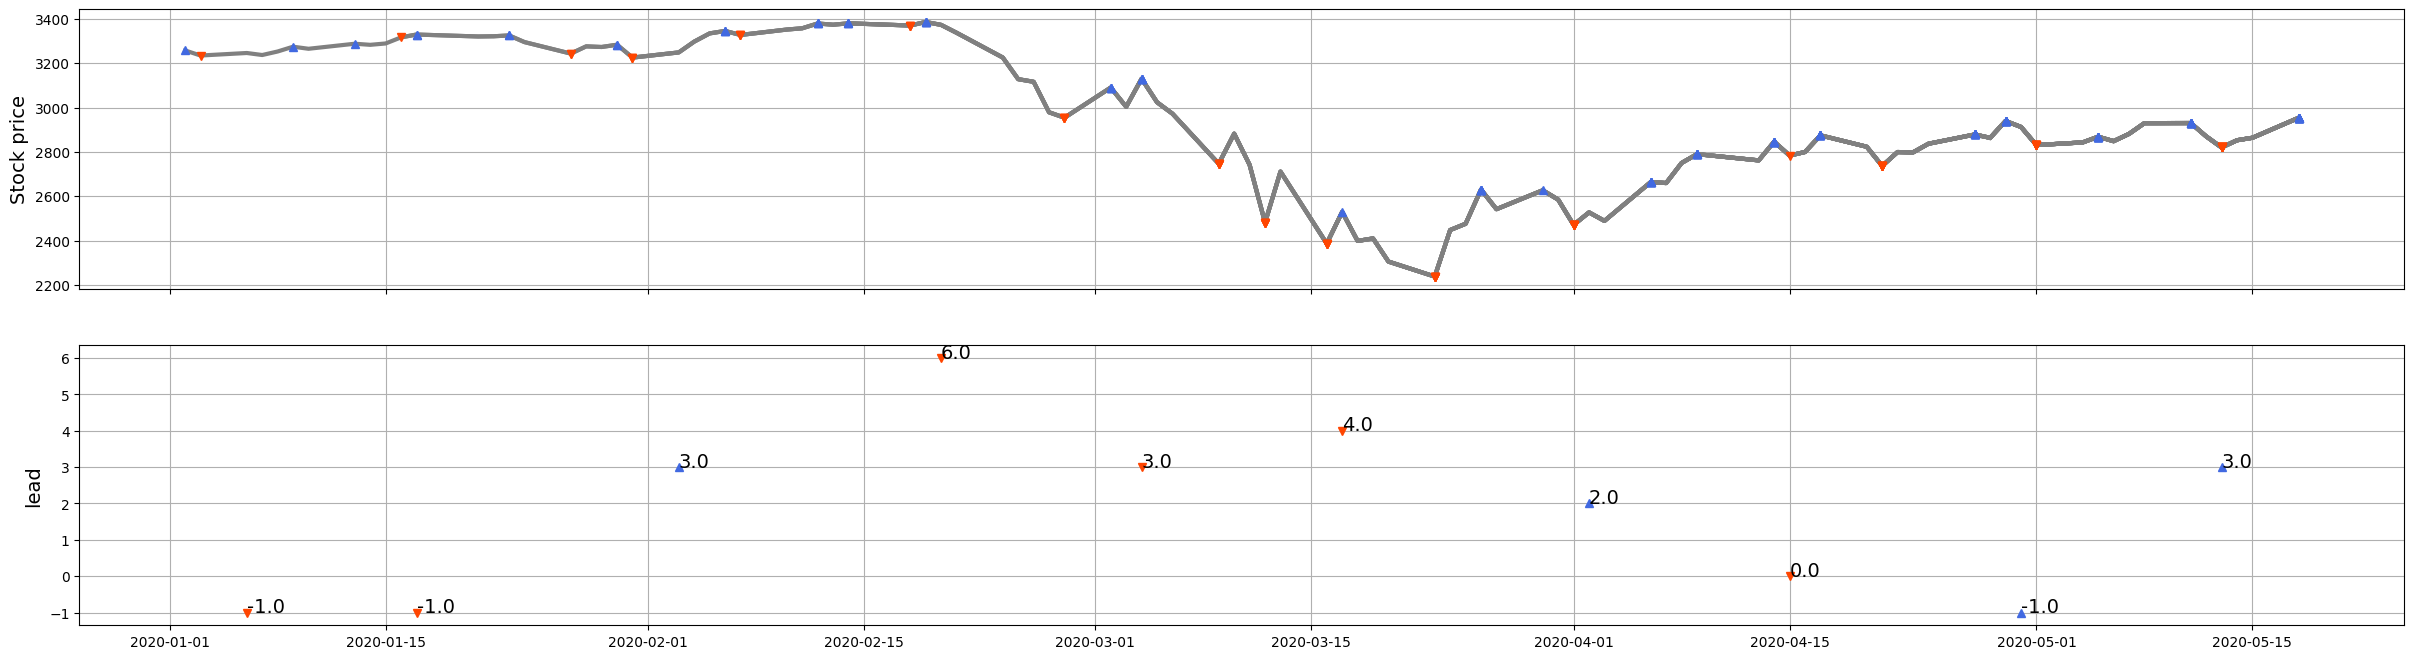

In [61]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

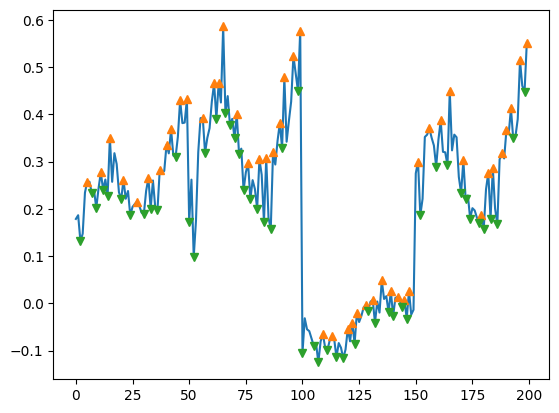

In [62]:
plt.plot(processed_signal['data_0'][0]['Close'])
plt.plot(processed_signal['data_0'][0]['peaks'], '^')
plt.plot(processed_signal['data_0'][0]['valleys'], 'v')

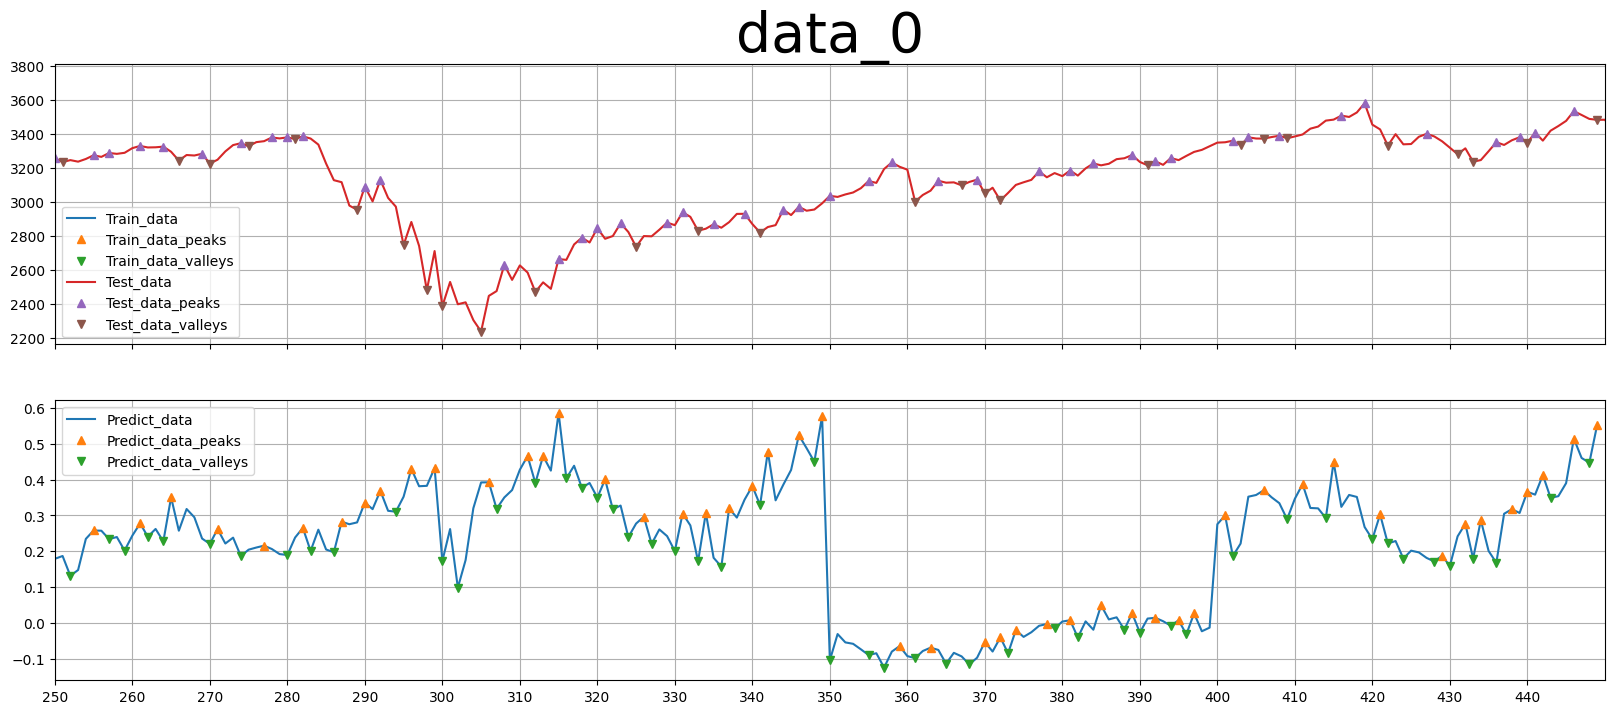

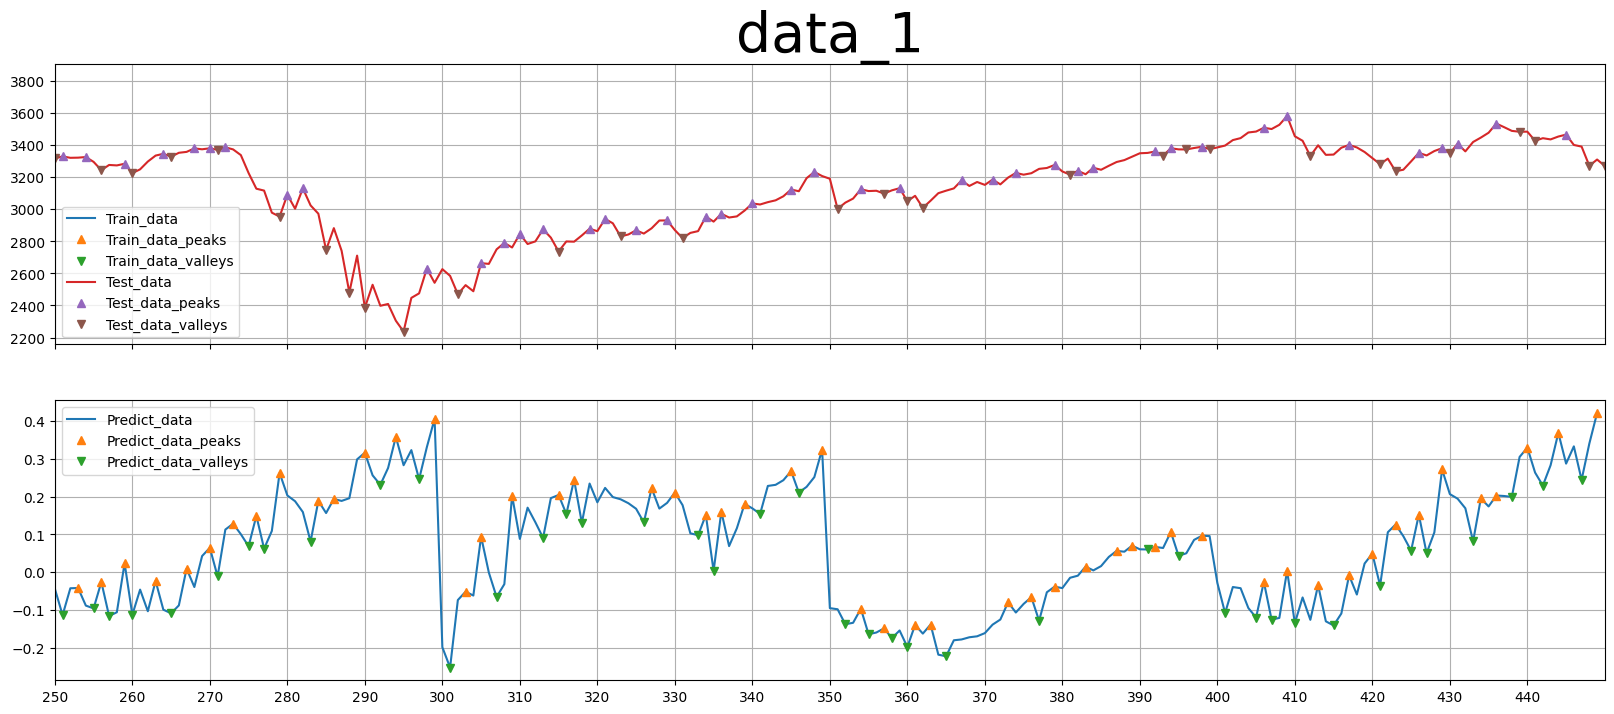

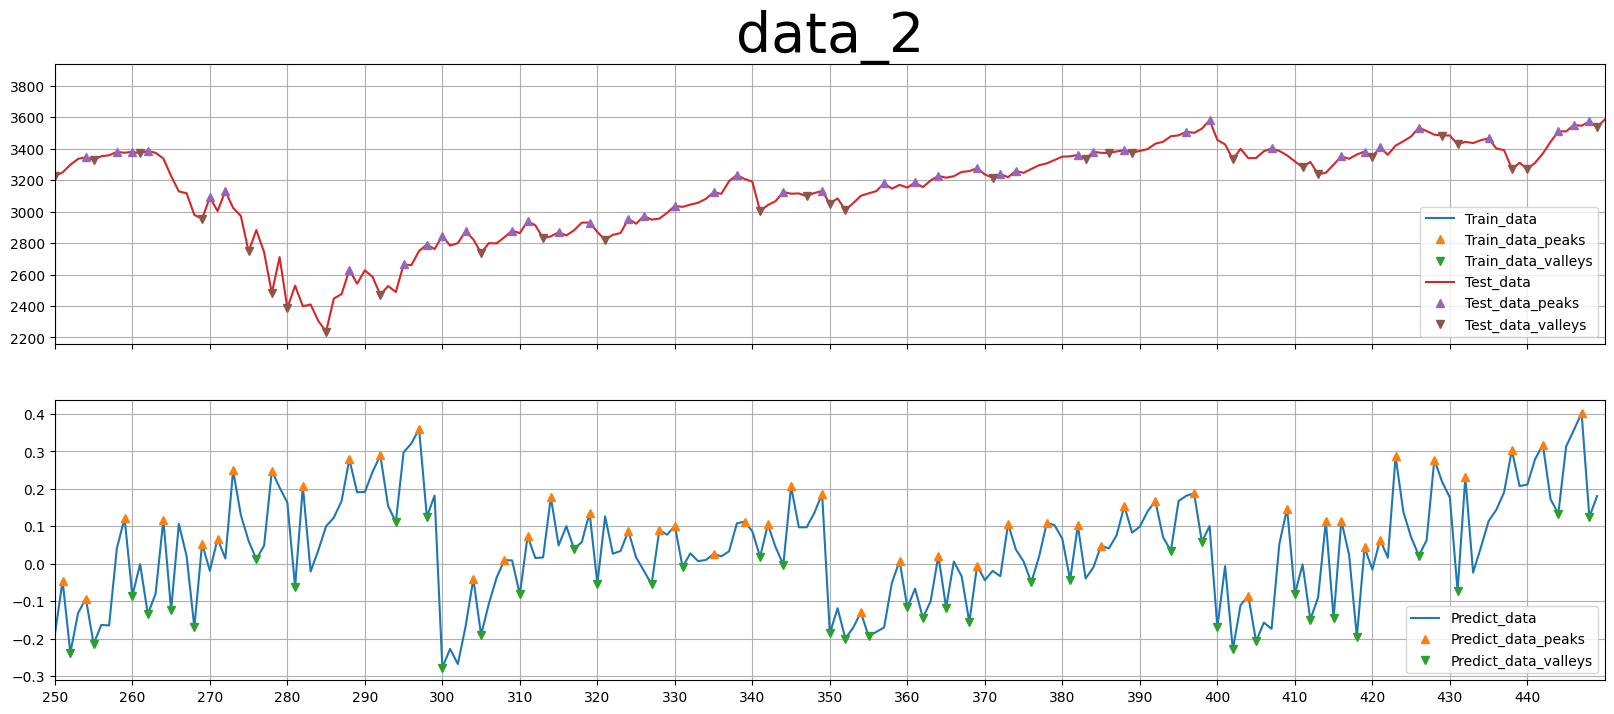

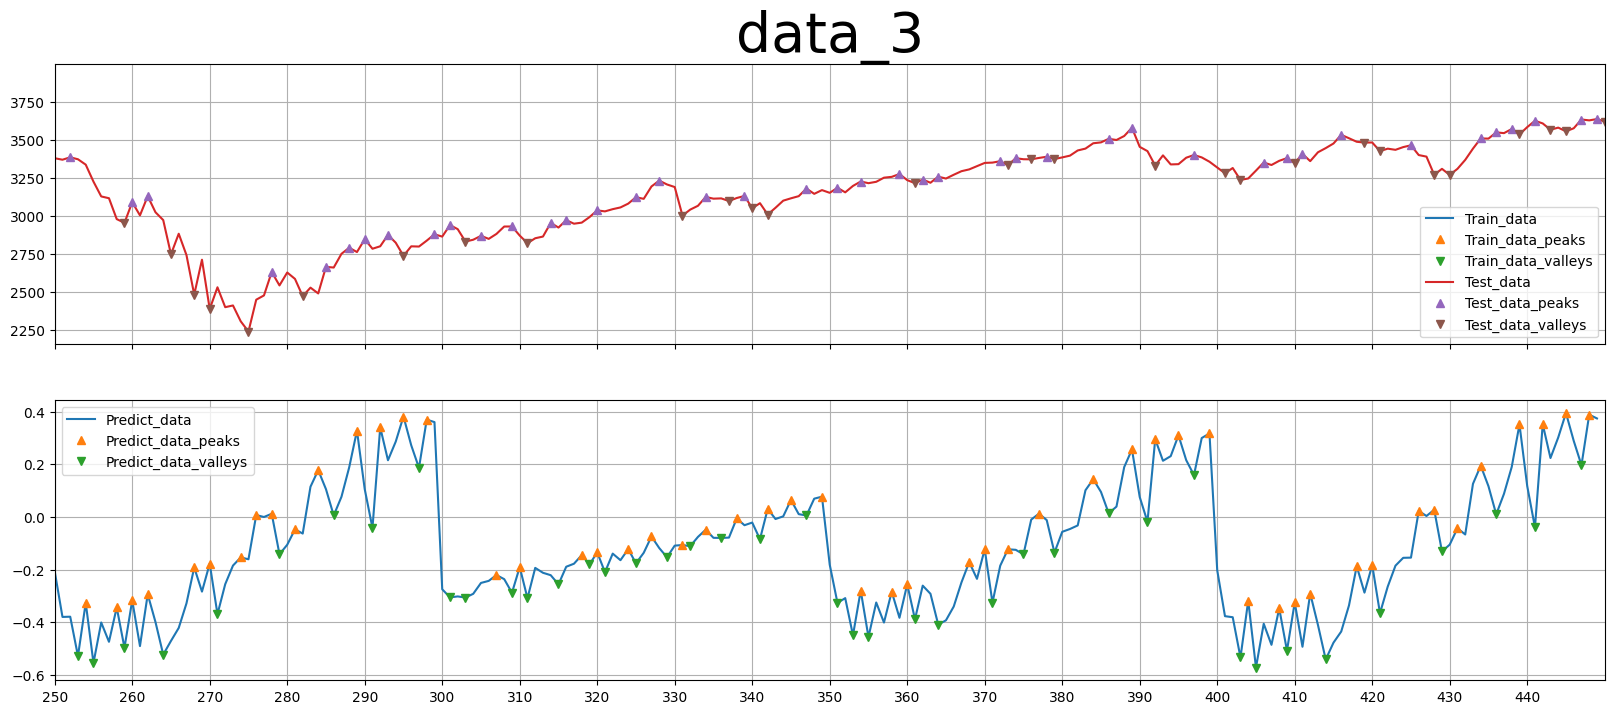

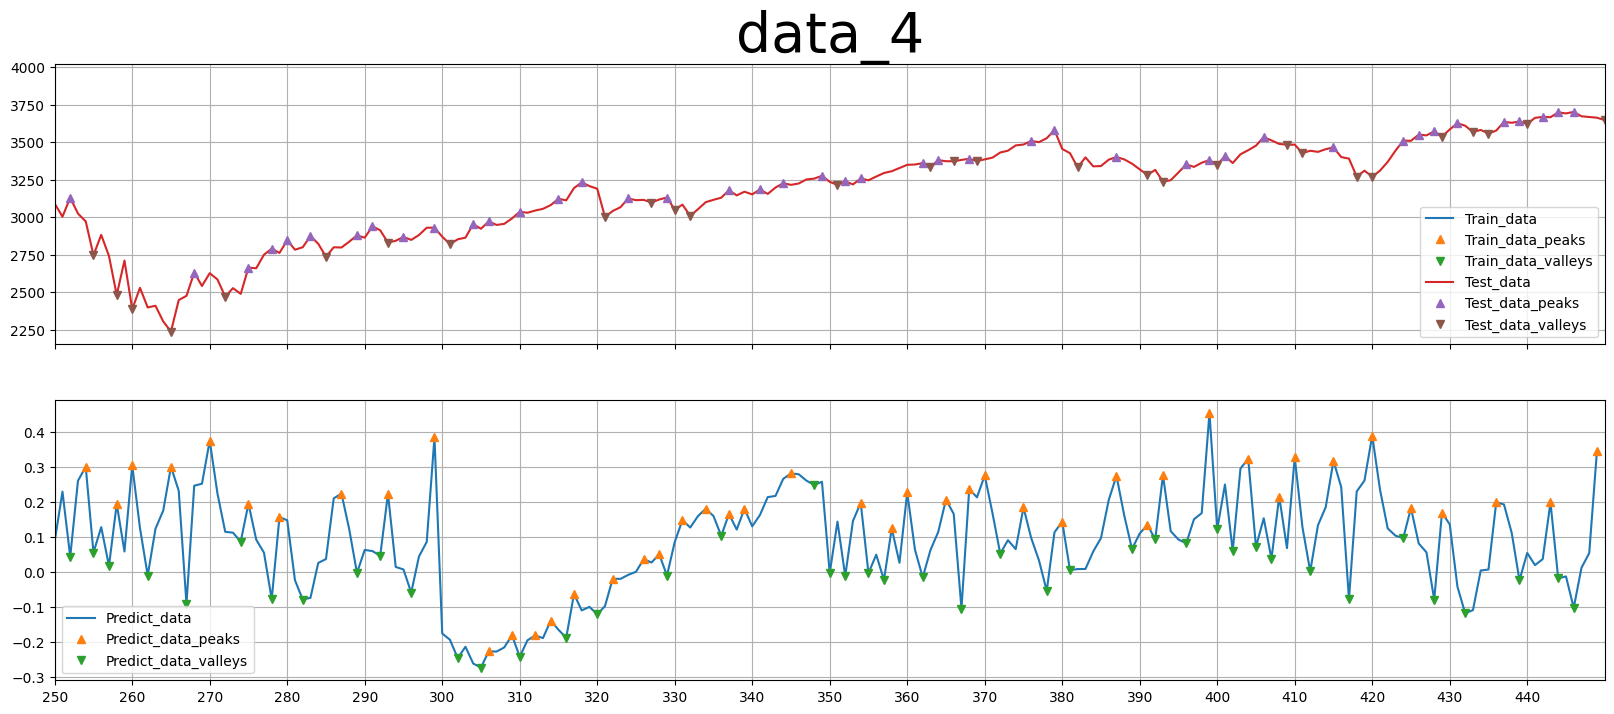

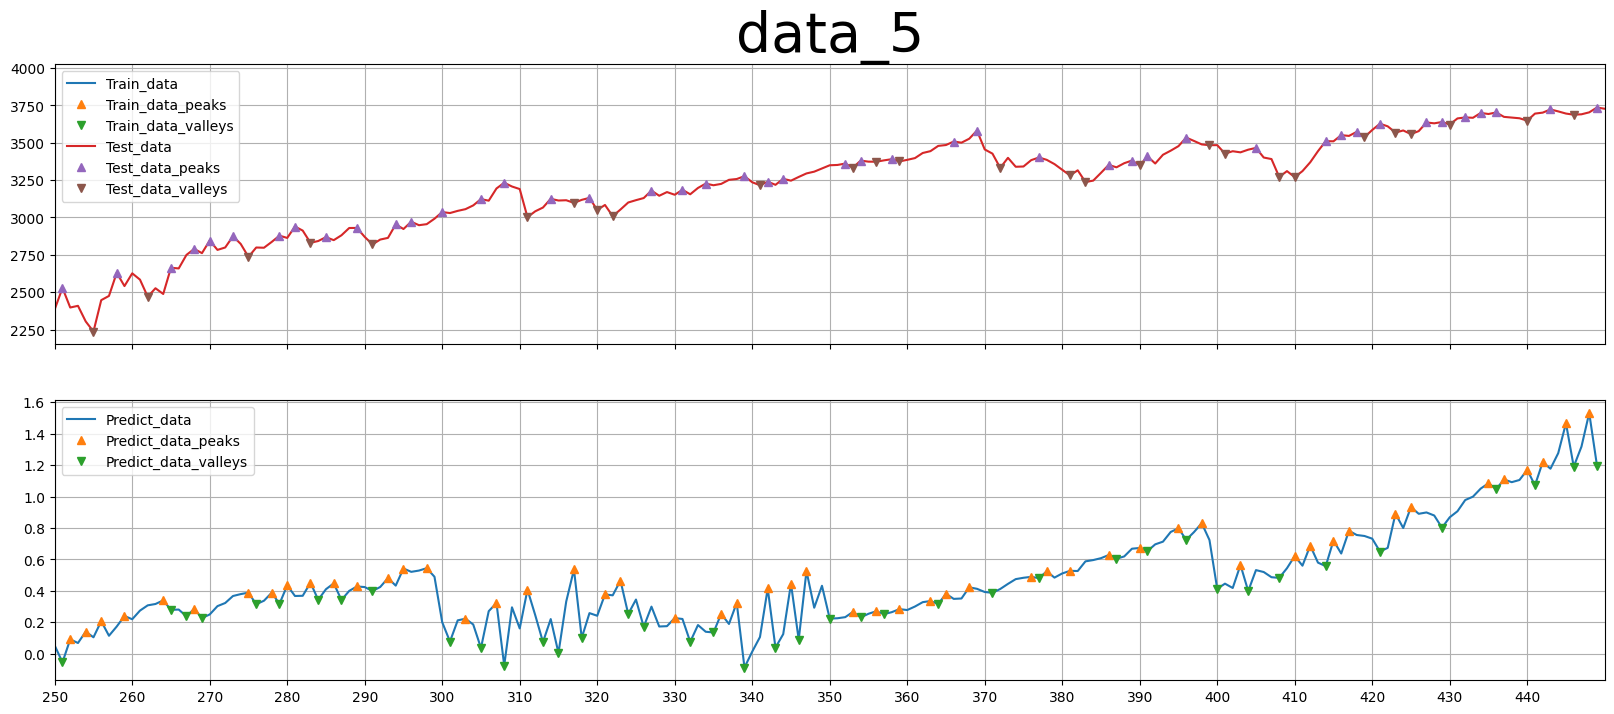

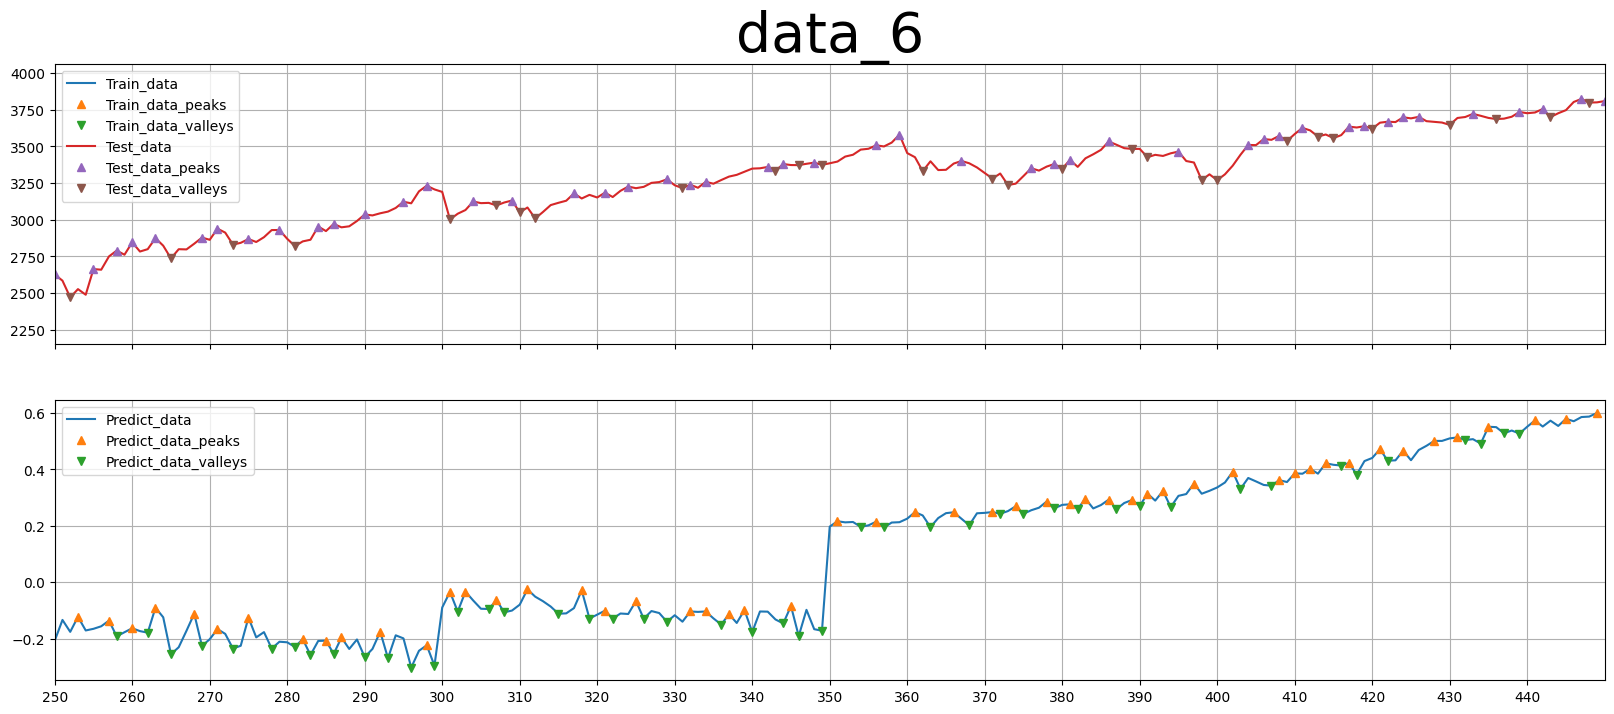

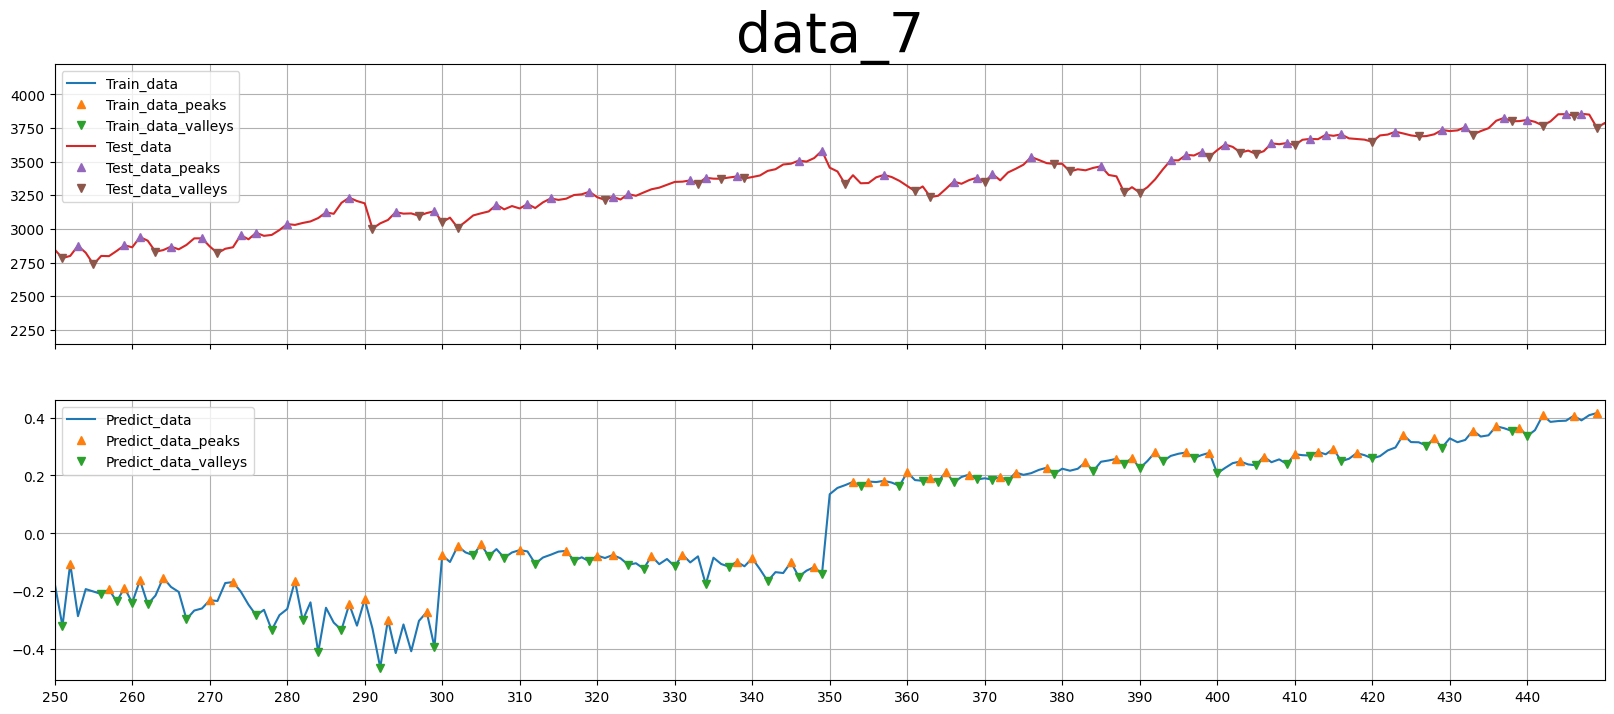

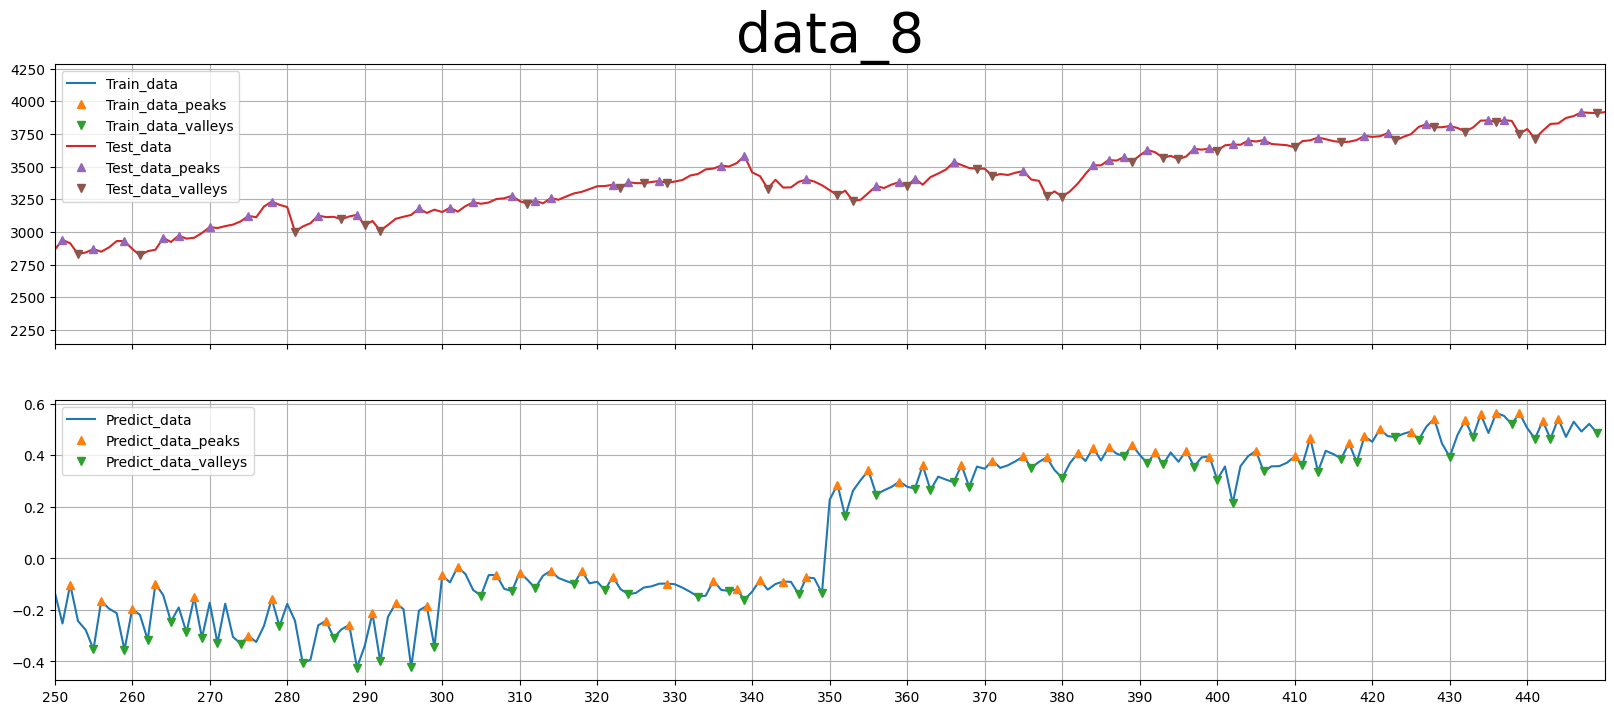

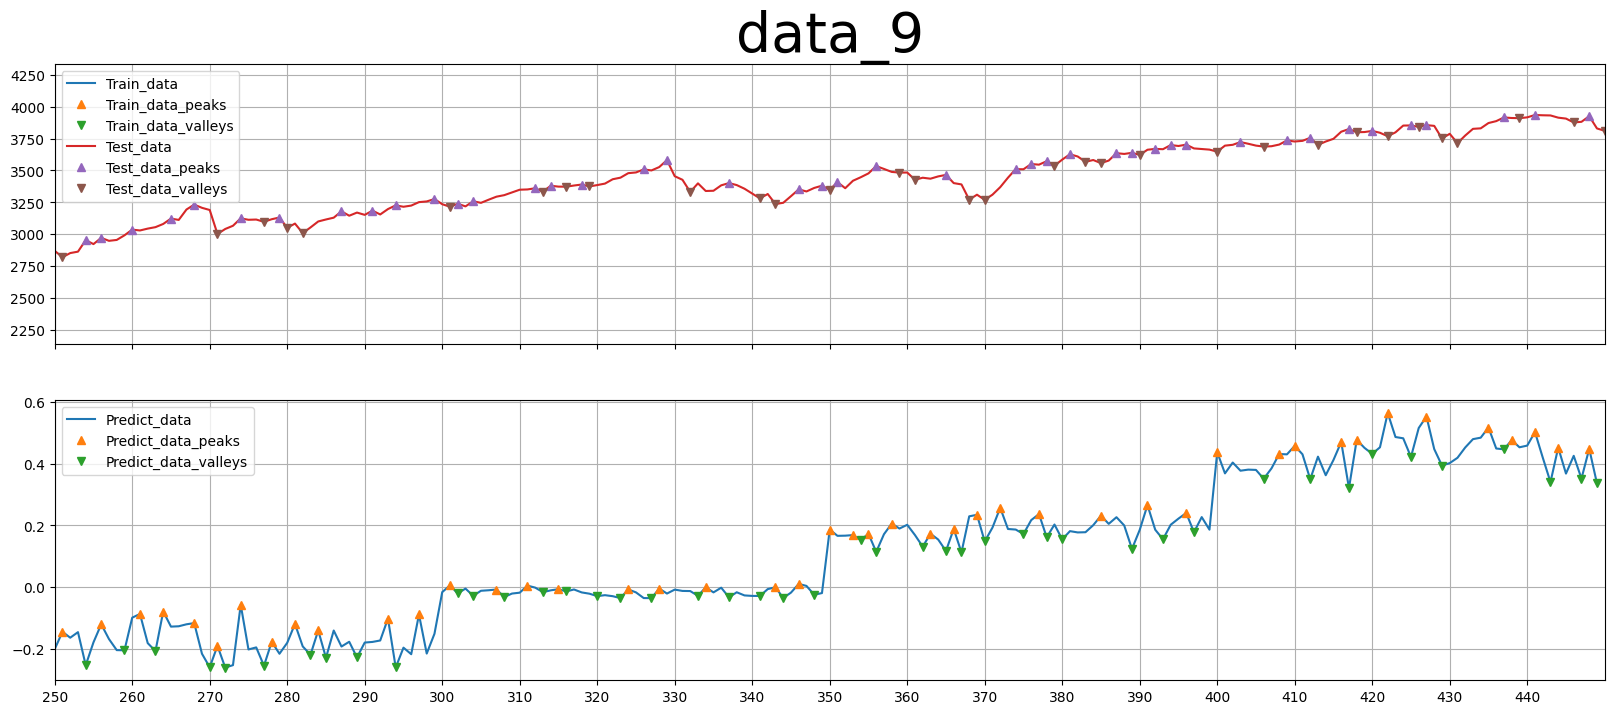

In [63]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'], label='Train_data')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^', label='Train_data_peaks')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v', label='Train_data_valleys')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'], label='Test_data')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^', label='Test_data_peaks')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v', label='Test_data_valleys')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'], label='Predict_data')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^', label='Predict_data_peaks')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v', label='Predict_data_valleys')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    axes[0].legend()
    axes[1].legend()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()

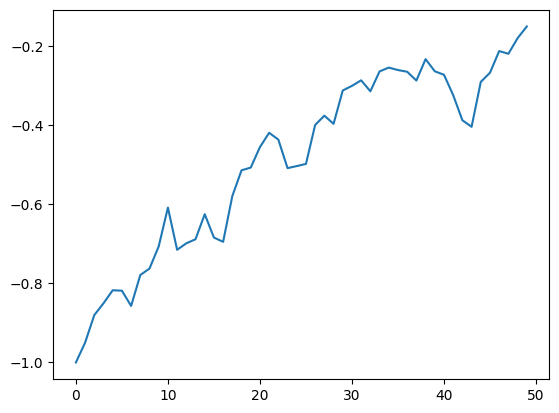

In [64]:
plt.plot(x_train['data_0'][0])

In [65]:
x_train['data_0'].shape[1]

50

In [66]:
for j in range(0, x_train[i].shape[1]):
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [67]:
len(x_train[i][0])

50

In [68]:
# x_start = 0
# x_end = x_start+slide
# for i in x_train:
#     x_start_copy = x_start
#     fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
#     axes[0].set_title(i, fontsize=40)
#     for j in range(0, x_train[i].shape[0]):
#         axes[0].plot(range(x_start, x_end), x_train[i][j], label=f'x_train_{j}')
#         axes[1].plot(range(x_end, x_end+slide), y_train[i][j], label=f'y_train_{j}')
#         x_start+=slide
#         x_end+=slide
#     axes[0].grid()
#     axes[1].grid()
#     axes[0].legend()
#     axes[1].legend()
#     plt.xticks(np.arange(x_start_copy, x_end, step=10))
#     plt.show()

In [69]:
processed_signal['data_0'][0]['Close'].values

array([ 0.17860456,  0.18645296,  0.13110778,  0.14738627,  0.23423925,
        0.25766298,  0.2571038 ,  0.23357913,  0.23945548,  0.20173092,
        0.24341667,  0.27736402,  0.24035612,  0.261994  ,  0.22724794,
        0.35042974,  0.25712362,  0.3176677 ,  0.29462764,  0.235187  ,
        0.22024058,  0.2616511 ,  0.22130488,  0.23773985,  0.18608354,
        0.20407934,  0.21014325,  0.21534918,  0.20593537,  0.19180311,
        0.18921787,  0.2379708 ,  0.26492366,  0.20057201,  0.25994316,
        0.20462152,  0.19684763,  0.2821711 ,  0.27517593,  0.28028294,
        0.3357184 ,  0.31727803,  0.36855966,  0.31264454,  0.31011456,
        0.3520122 ,  0.43002385,  0.3812515 ,  0.3823806 ,  0.43230194,
        0.1723649 ,  0.2617309 ,  0.09798169,  0.17509139,  0.3198657 ,
        0.3918575 ,  0.39223373,  0.3183352 ,  0.34997606,  0.37057662,
        0.42726004,  0.46558166,  0.3901016 ,  0.46564615,  0.42485812,
        0.5856986 ,  0.4033838 ,  0.4384377 ,  0.37693438,  0.39

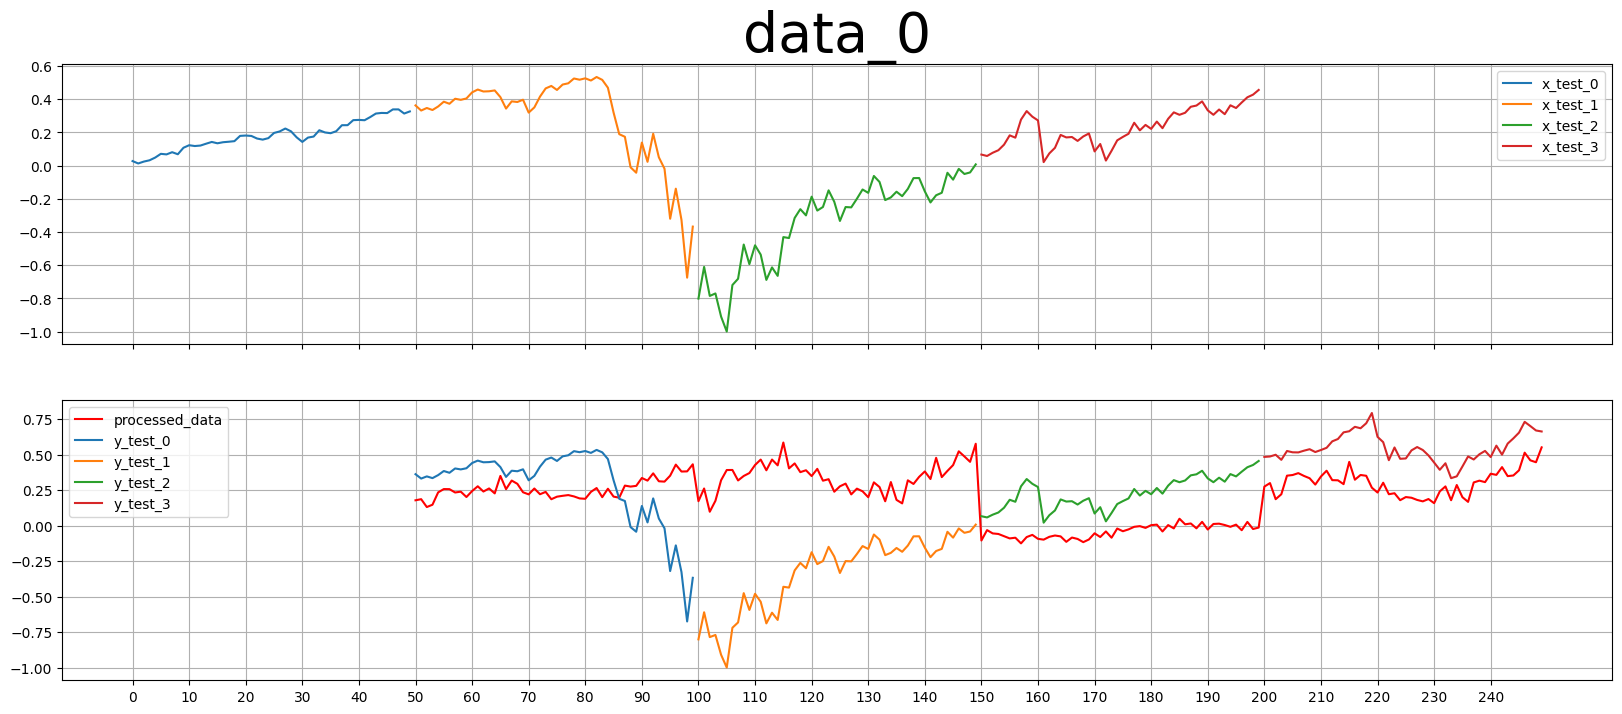

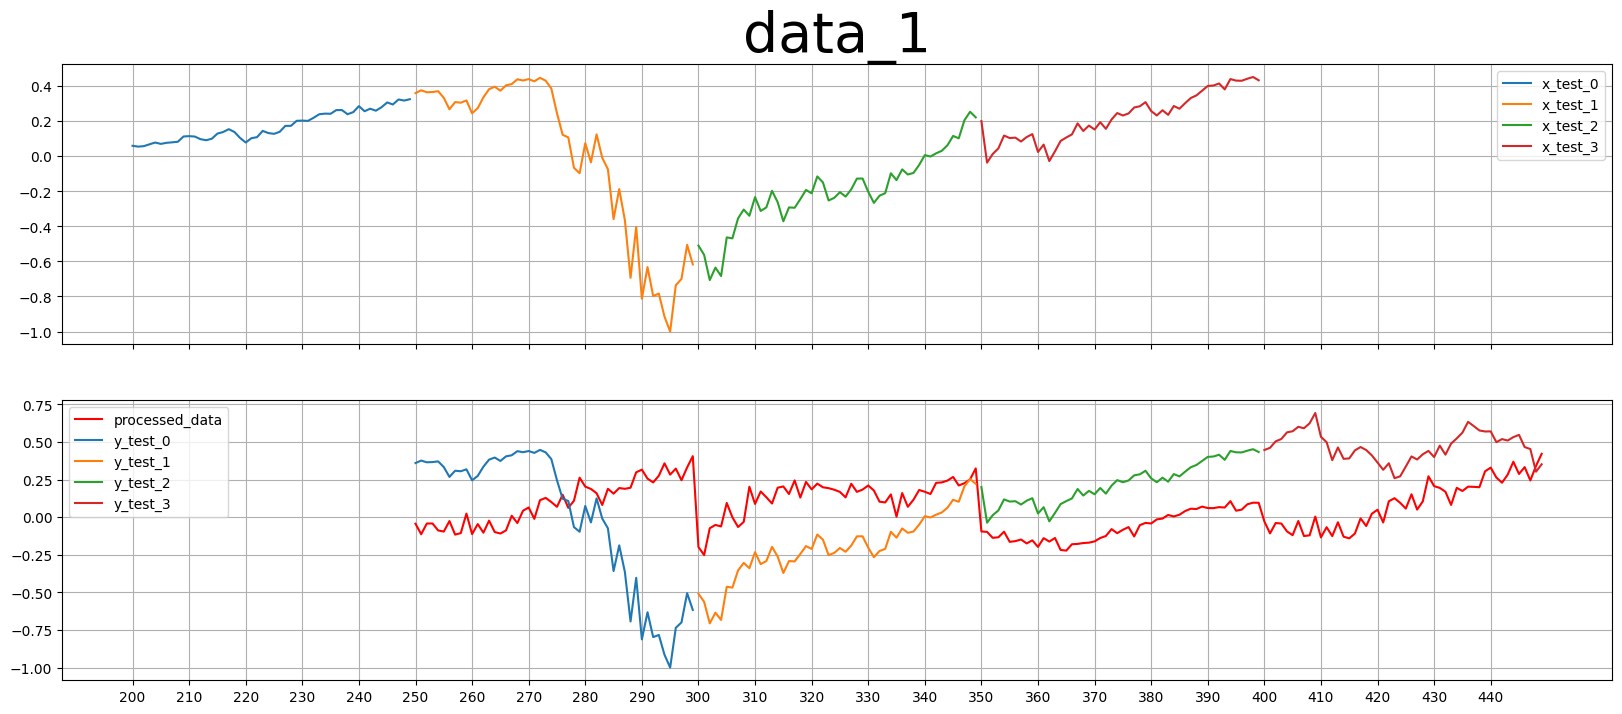

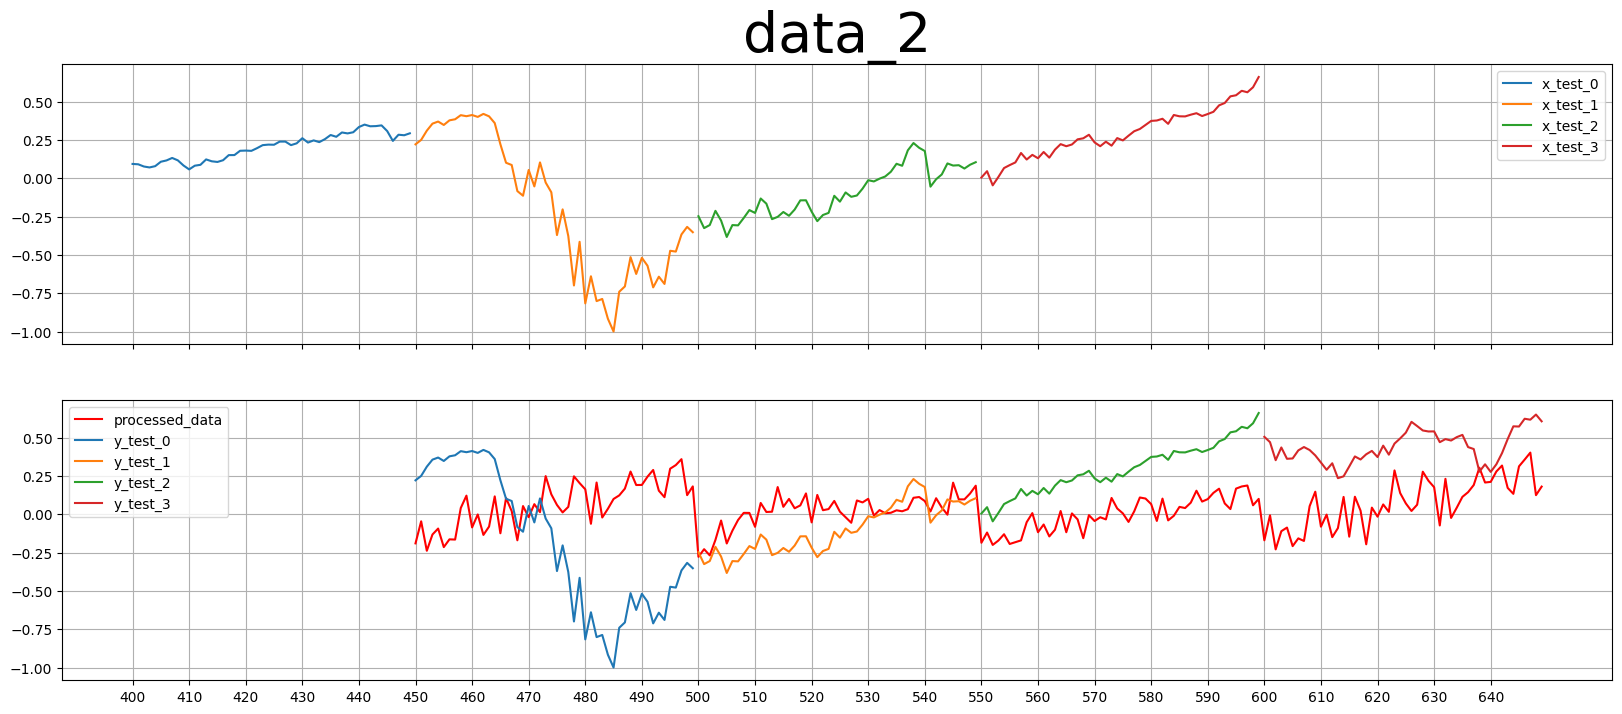

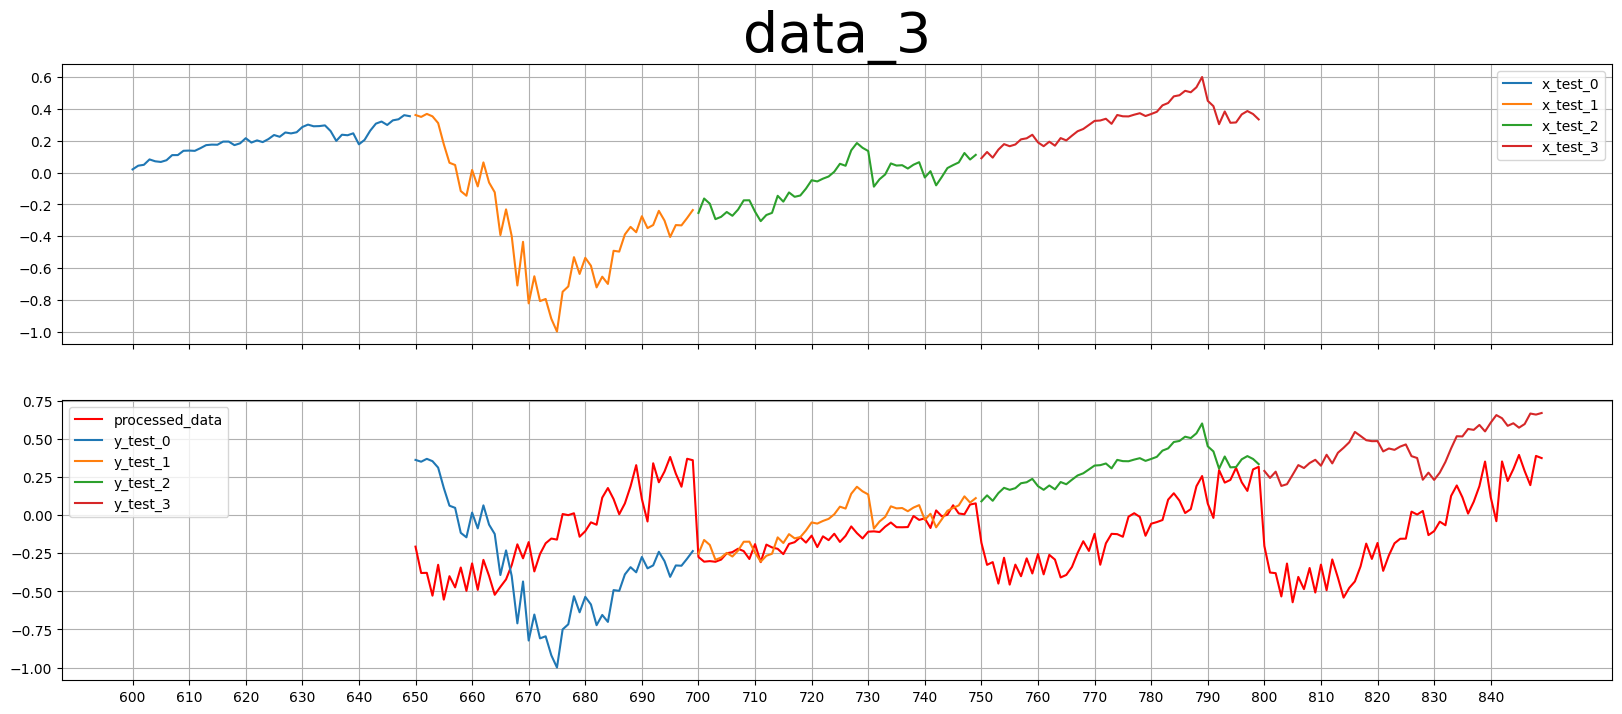

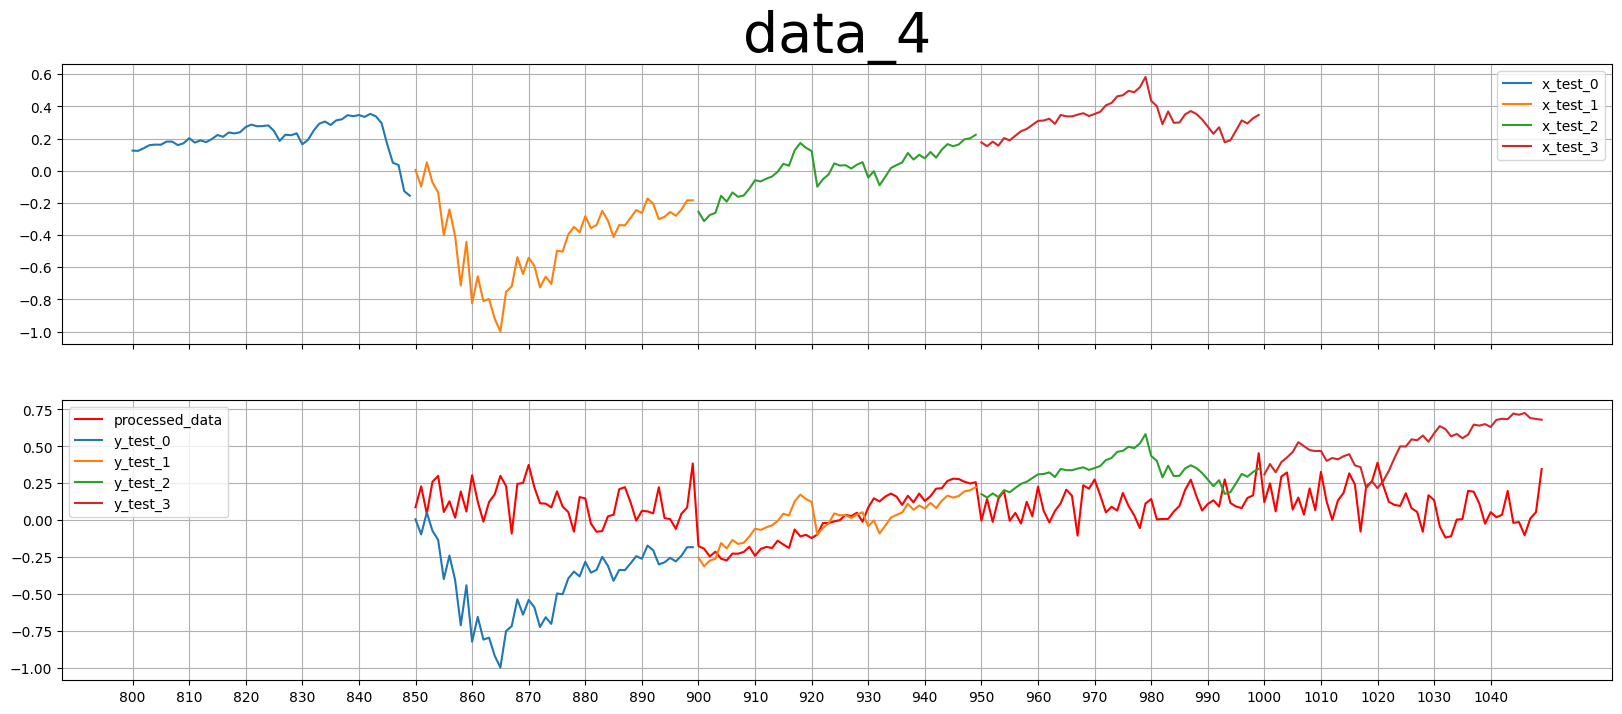

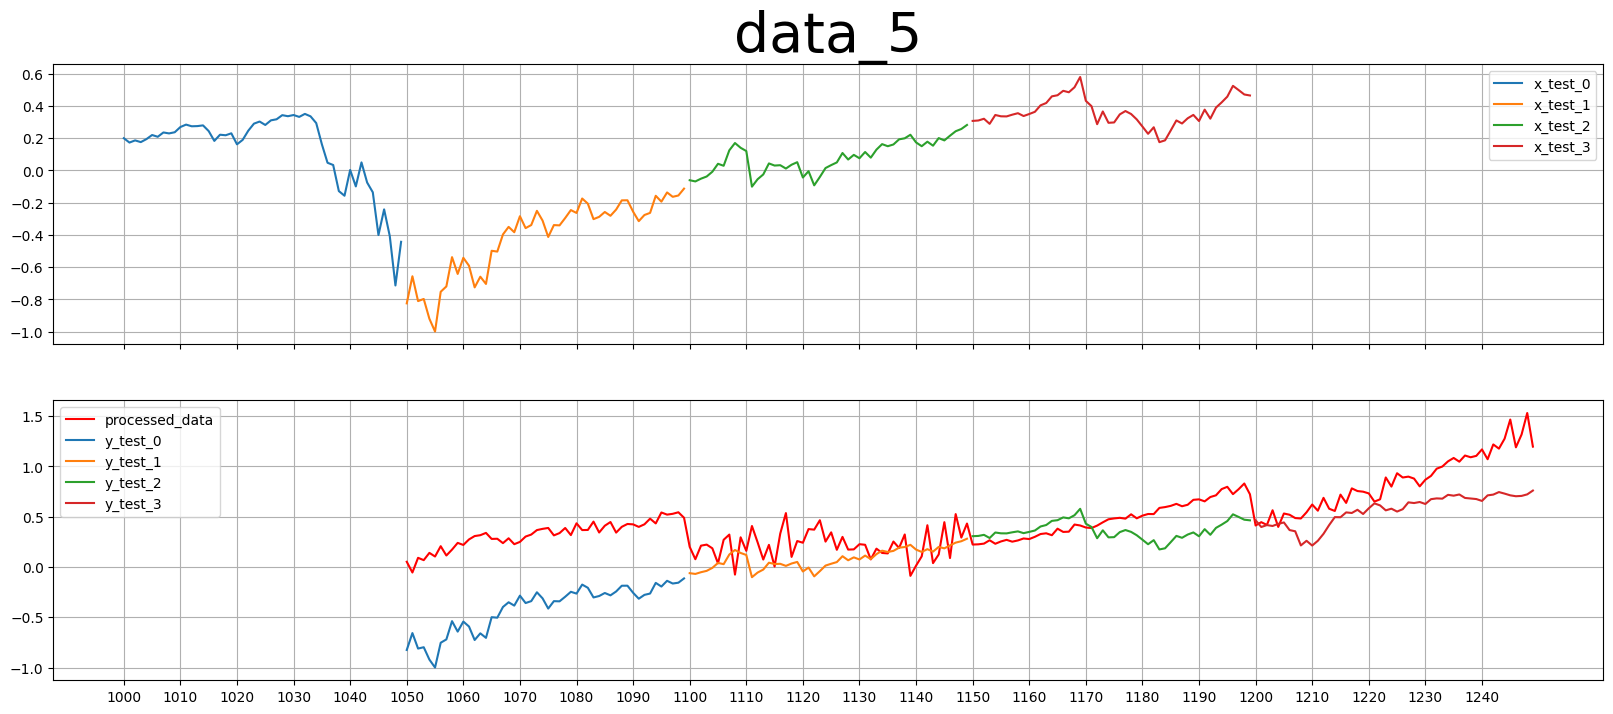

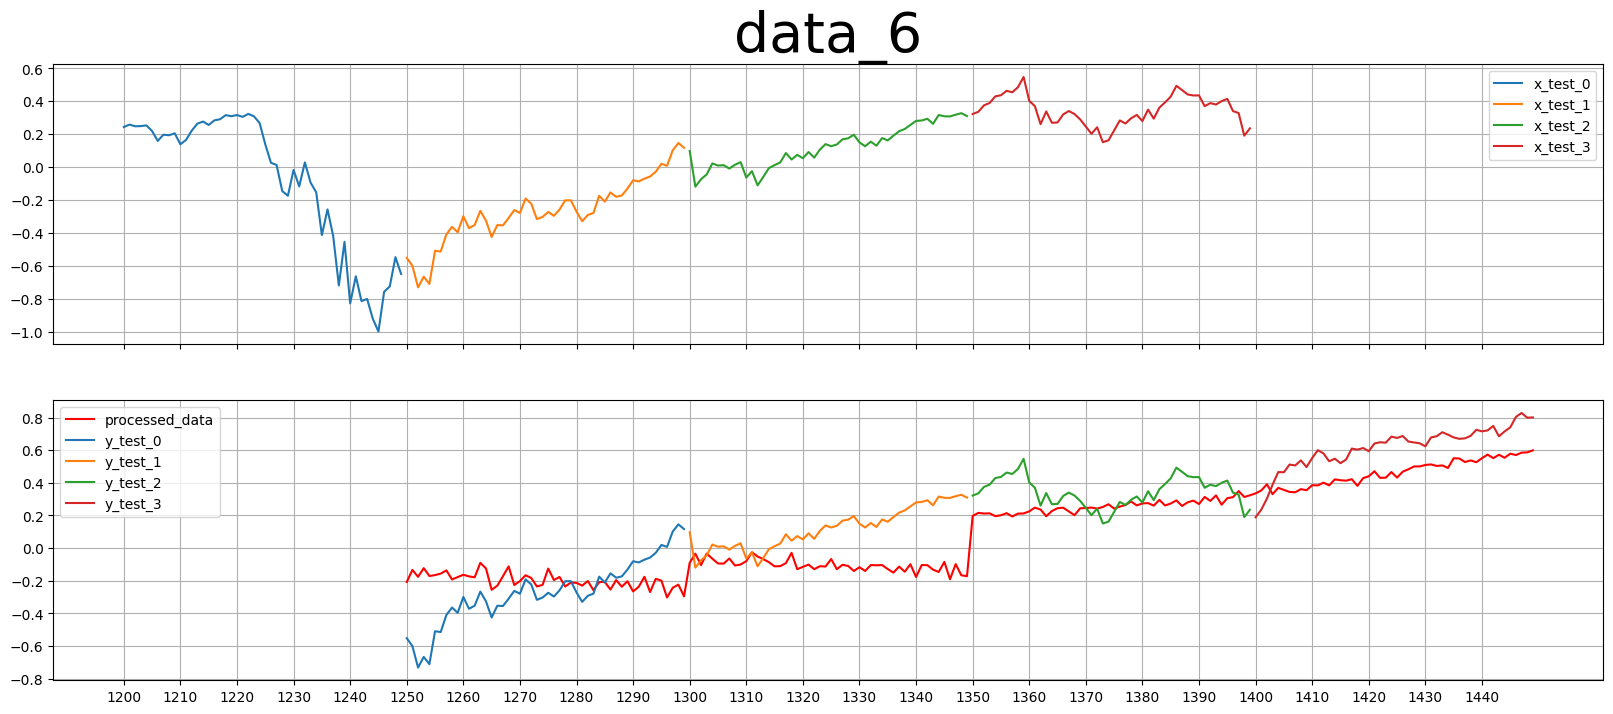

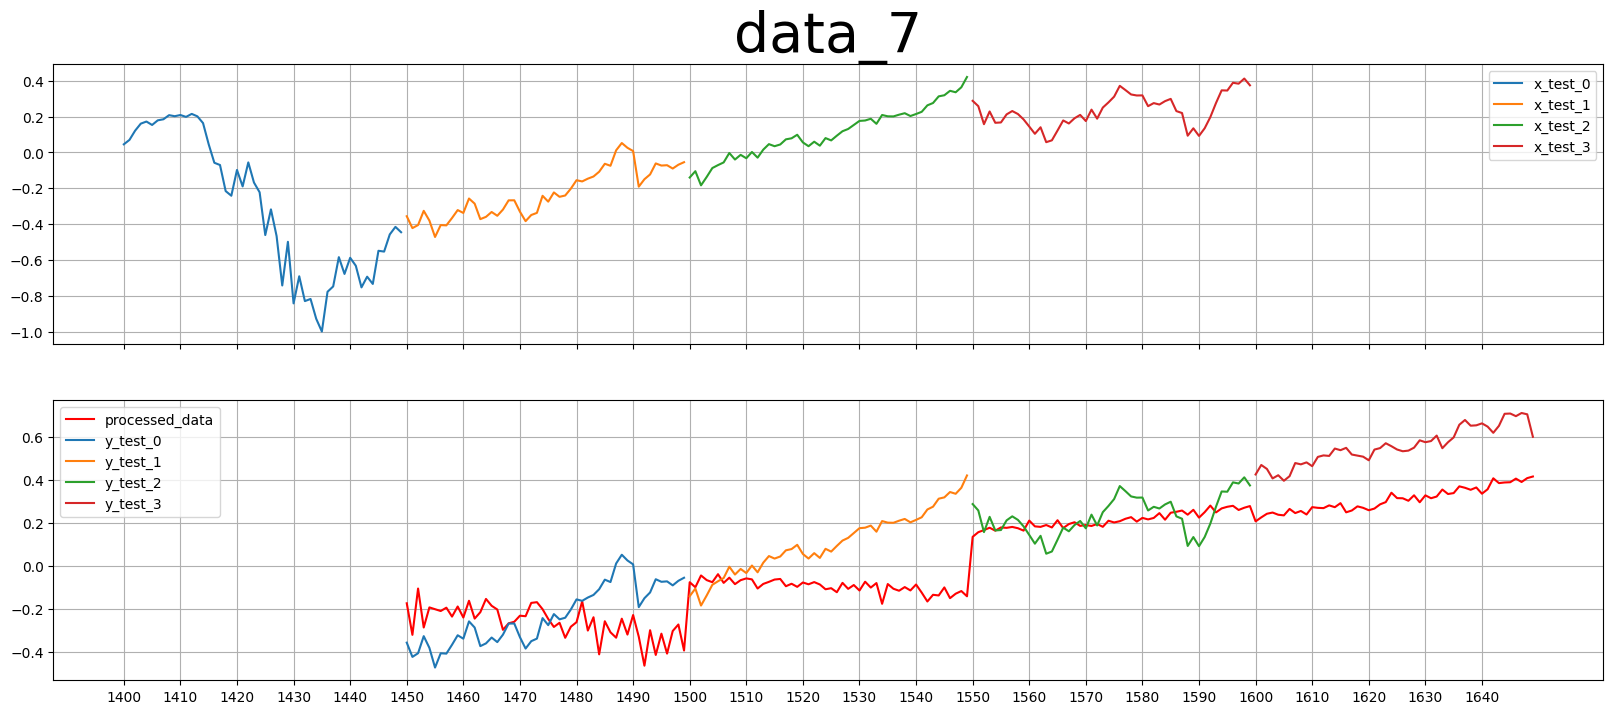

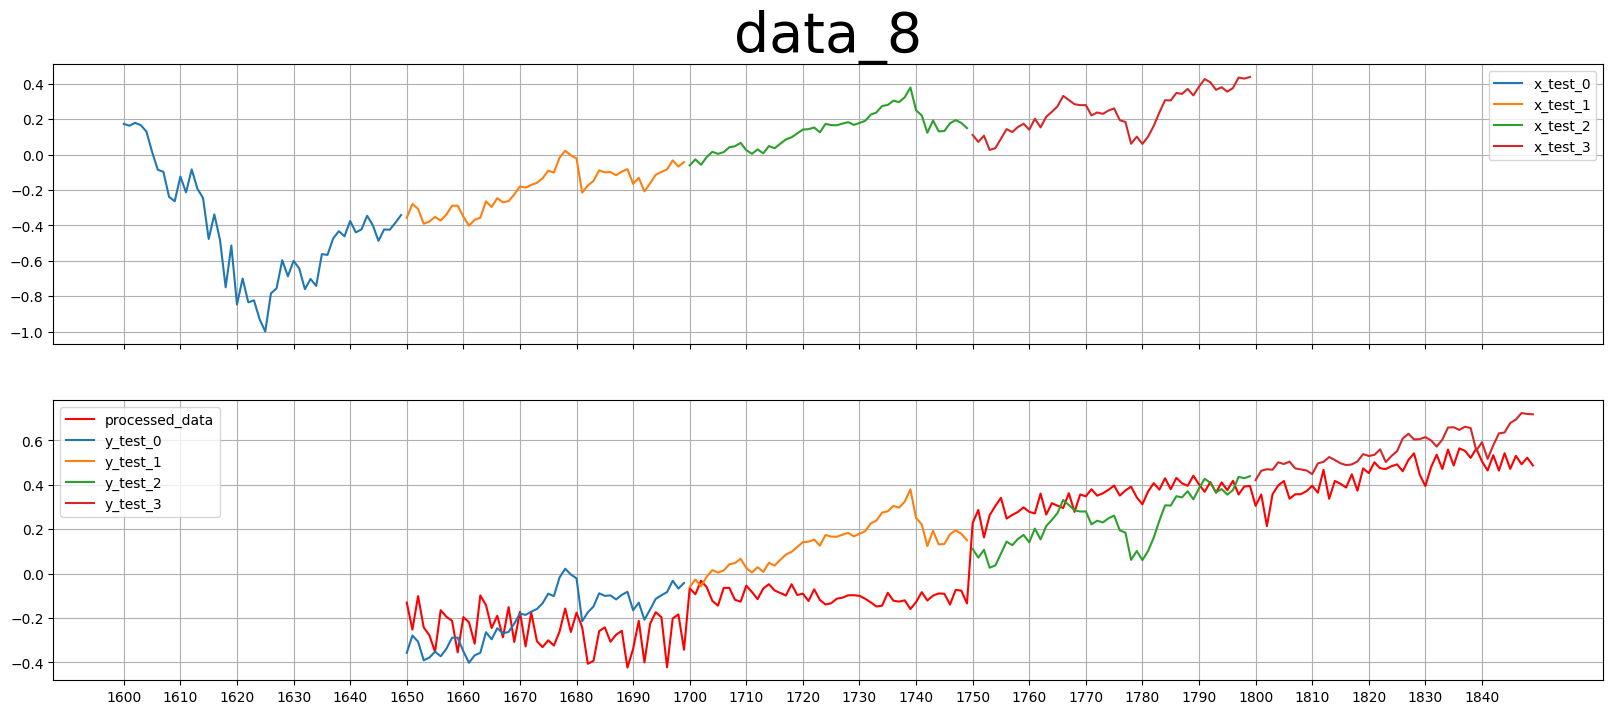

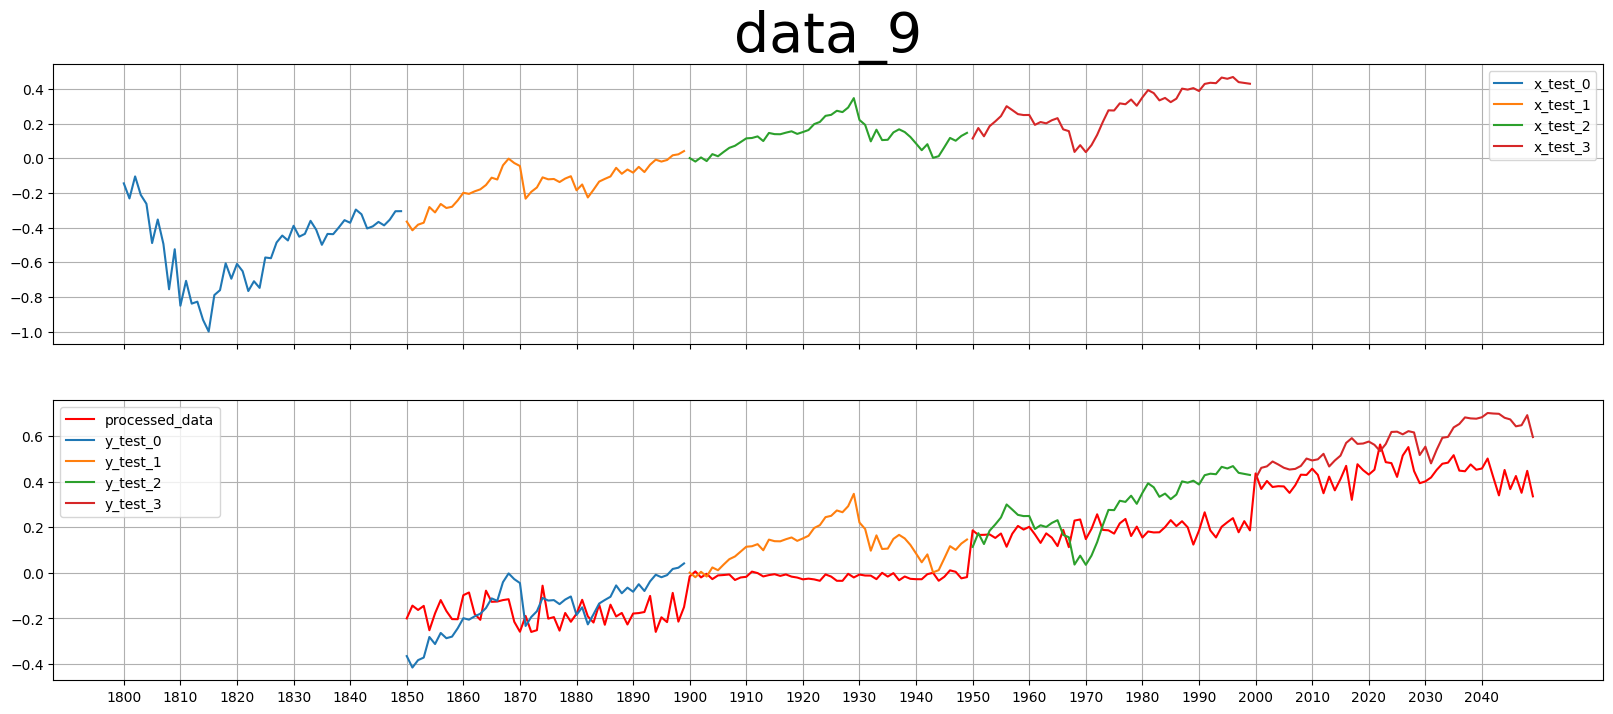

In [70]:
x_start = 0
x_end = x_start+slide
for i in x_test:
    x_start_copy = x_start
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    plot_processed_data = processed_signal[i][0]['Close'].values
    axes[1].plot(range(x_end, x_end+len(plot_processed_data)), plot_processed_data, 'r',label=f'processed_data')
    for j in range(0, x_test[i].shape[0]):
        axes[0].plot(range(x_start, x_end), x_test[i][j], label=f'x_test_{j}')
        axes[1].plot(range(x_end, x_end+slide), y_test[i][j], label=f'y_test_{j}')
        x_start+=slide
        x_end+=slide
    
    axes[0].grid()
    axes[1].grid()
    axes[0].legend()
    axes[1].legend()
    plt.xticks(np.arange(x_start_copy, x_end, step=10))
    plt.show()